# ODM2 Example 3: Use ODM2 API to Retrieve Data for Manipulation or Analysis

This example shows how to connect to an ODM2 database using the ODM2 Python API, retrieve data, and use it for analysis or visualization. This example uses SQLite for the database because it doesn't require a server. However, the ODM2 Python API demonstrated here can alse be used with ODM2 databases implemented in MySQL, PostgresSQL or Microsoft SQL Server.

More details of the ODM2 Python API and its source code and latest development can be found at: https://github.com/ODM2/ODM2PythonAPI

In [1]:
%matplotlib inline

import sys
import os
import sqlite3

import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd

from odm2api.ODMconnection import dbconnection
import odm2api.ODM2.services.readService as odm2rs

## Make a Connection to the ODM2 SQLite Database

For this example, an ODM2 SQLite database has been created and loaded with water quality sample data from multiple monitoring sites in the iUTAH Gradients Along Mountain to Urban Transitions (GAMUT) water quality monitoring network. Water quality samples have been collected and analyzed for nitrogen, phosphorus, total coliform, E-coli, and some water isotopes.

The example database is located in the `wshp2017_tutorial_content/data` directory on this JupyterHub server.

In [2]:
# Assign directory paths and SQLite file name
dpth = os.getcwd()
dbname_sqlite = "ODM2_Example2.sqlite"

sqlite_pth = os.path.join(dpth, os.path.pardir, "data", dbname_sqlite)

In [3]:
try:
    session_factory = dbconnection.createConnection('sqlite', sqlite_pth, 2.0)
    read = odm2rs.ReadODM2(session_factory)
    print("Database connection successful!")
except Exception as e:
    print("Unable to establish connection to the database: ", e)

Database connection successful!


## Run Some Basic Queries on the ODM2 Database

This section shows some example of how to use the API to run both simple and more advanced queries on the ODM2 database, as well as how to examine the query output in convenient ways thanks to Python tools.

Simple query functions like **getVariables( )** return objects similar to the entities in ODM2, and individual attributes can then be retrieved from the objects returned. 

### Get all Variables
A simple query with simple output.

In [4]:
# Get all of the Variables from the ODM2 database then read the records
# into a Pandas DataFrame to make it easy to view and manipulate
allVars = read.getVariables()

In [5]:
# Get all of the Variables from the ODM2 database then read the records
# into a Pandas DataFrame to make it easy to view and manipulate
allVars = read.getVariables()

variables_df = pd.DataFrame.from_records([vars(variable) for variable in allVars], index='VariableID')
variables_df.head(10)

,NoDataValue,SpeciationCV,VariableCode,VariableDefinition,VariableNameCV,VariableTypeCV,_sa_instance_state
VariableID,,,,,,,
1,-9999.0000000000,N,TN,None,"Nitrogen, total",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
2,-9999.0000000000,P,TP,None,"Phosphorus, total",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
3,-9999.0000000000,N,Nitrate,None,"Nitrogen, dissolved nitrite (NO2) + nitrate (NO3)",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
4,-9999.0000000000,N,Ammonia,None,"Nitrogen, NH4",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
5,-9999.0000000000,P,Phosphate,None,"Phosphorus, orthophosphate dissolved",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
6,-9999.0000000000,Not Applicable,Tcoliform,None,"Coliform, total",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
7,-9999.0000000000,Not Applicable,E-Coli,None,E-coli,Water quality,<sqlalchemy.orm.state.InstanceState object at ...
8,-9999.0000000000,C,DOC,None,"Carbon, dissolved organic",Water quality,<sqlalchemy.orm.state.InstanceState object at ...
9,-9999.0000000000,N,TDN,None,"Nitrogen, total dissolved",Water quality,<sqlalchemy.orm.state.InstanceState object at ...


### Get all People
Another simple query.

In [6]:
allPeople = read.getPeople()
pd.DataFrame.from_records([vars(person) for person in allPeople]).head()

,PersonFirstName,PersonID,PersonLastName,PersonMiddleName,_sa_instance_state
0,Nancy,1,Mesner,,<sqlalchemy.orm.state.InstanceState object at ...
1,Dane,2,Brophy,,<sqlalchemy.orm.state.InstanceState object at ...
2,Ben,3,Rider,,<sqlalchemy.orm.state.InstanceState object at ...
3,Michelle,4,Baker,,<sqlalchemy.orm.state.InstanceState object at ...
4,Erin,5,Jones,,<sqlalchemy.orm.state.InstanceState object at ...


### Site Sampling Features: pass arguments to the API query

Some of the API functions accept arguments that let you subset what is returned. For example, I can query the database using the **getSamplingFeatures( )** function and pass it a SamplingFeatureType of "Site" to return a list of those SamplingFeatures that are Sites.

In [7]:
# Get all of the SamplingFeatures from the ODM2 database that are Sites
siteFeatures = read.getSamplingFeatures(type='Site')

# Read Sites records into a Pandas DataFrame
# ()"if sf.Latitude" is used only to instantiate/read Site attributes)
df = pd.DataFrame.from_records([vars(sf) for sf in siteFeatures if sf.Latitude])

Since we know this is a *geospatial* dataset (Sites, which have latitude and longitude), we can use more specialized (spatialized?) Python tools like `GeoPandas` (geospatially enabled Pandas) and `Folium` interactive maps.

In [8]:
# Create a GeoPandas GeoDataFrame from Sites DataFrame
ptgeom = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=ptgeom, crs={'init': 'epsg:4326'})
gdf.head(5)

,ElevationDatumCV,Elevation_m,FeatureGeometryWKT,Latitude,Longitude,SamplingFeatureCode,SamplingFeatureDescription,SamplingFeatureGeotypeCV,SamplingFeatureID,SamplingFeatureName,SamplingFeatureTypeCV,SamplingFeatureUUID,SiteTypeCV,SpatialReferenceID,_sa_instance_state,geometry
0,EGM96,1356.0,None,40.745078,-111.854449,RB_1300E,None,None,1,Red Butte Creek at 1300E (downstream of spring),Site,0DDE8EF6-EC2F-42C0-AB50-20C6C02E89B2,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.854449 40.745078)
1,EGM96,1356.0,None,40.745106,-111.854389,RB_1300ESpring,None,None,2,Spring that enters Red Butte Creek at 1300E,Site,9848BBFE-EA3F-4918-A324-13E8EDE5381C,Spring,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.854389 40.745106)
2,EGM96,1289.0,None,40.741583,-111.917667,RB_900W_BA,None,None,3,Red Butte Creek terminus at Jordan River at 13...,Site,688017BC-9E02-4444-A21D-270366BE2348,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.917667 40.741583)
3,EGM96,1519.0,None,40.766134,-111.826530,RB_Amphitheater,None,None,4,Red Butte Creek below Red Butte Garden Amphith...,Site,9CFE685B-5CDA-4E38-98D9-406D645C7D21,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.82653 40.766134)
4,EGM96,1648.0,None,40.779602,-111.806669,RB_ARBR_AA,None,None,5,Red Butte Creek above Red Butte Reservoir Adan...,Site,98C7F63A-FDFB-4898-87C6-5AA8EC34D1E4,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.806669 40.779602)


In [9]:
# Number of records (features) in GeoDataFrame
len(gdf)

25

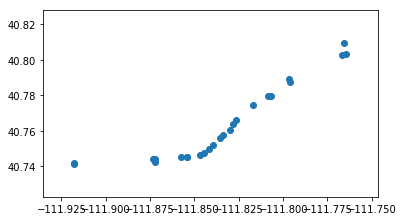

In [10]:
# A trivial plot, easy to generate thanks to GeoPandas
gdf.plot();

A site has a `SiteTypeCV`. Let's examine the site type distribution, and use that information to create a new GeoDataFrame column to specify a map marker color by `SiteTypeCV`.

In [11]:
gdf['SiteTypeCV'].value_counts()

Stream    24
Spring     1
Name: SiteTypeCV, dtype: int64

In [12]:
gdf["color"] = gdf.apply(lambda feat: 'green' if feat['SiteTypeCV'] == 'Stream' else 'red', axis=1)

Note: While the database holds a copy of the **ODM2 Controlled Vocabularies**, the complete description of each CV term is available from a web request to the CV API at http://vocabulary.odm2.org. Want to know more about how a "spring" is defined? Here's one simple way, using `Pandas` to access and parse the CSV web service response.

In [13]:
sitetype = 'spring'
pd.read_csv("http://vocabulary.odm2.org/api/v1/sitetype/{}/?format=csv".format(sitetype))

,term,name,definition,category,provenance,provenance_uri,note
0,spring,Spring,A location at which the water table intersects...,Spring Sites,Adapted from USGS Site Types.,NaN,http://wdr.water.usgs.gov/nwisgmap/help/sitety...


**Now we'll create an interactive and helpful `Folium` map of the sites.** This map features:
- Automatic panning to the location of the sites (no hard wiring, except for the zoom scale), based on GeoPandas functionality and information from the ODM2 Site Sampling Features
- Color coding by `SiteTypeCV` 
- Marker clustering
- Simple marker pop ups with content from the ODM2 Site Sampling Features

In [14]:
c = gdf.unary_union.centroid # GeoPandas heavy lifting
m = folium.Map(location=[c.y, c.x], tiles='CartoDB positron', zoom_start=11)

marker_cluster = folium.MarkerCluster().add_to(m)
for idx, feature in gdf.iterrows():
    folium.Marker(location=[feature.geometry.y, feature.geometry.x], 
                  icon=folium.Icon(color=feature['color']),
                  popup="{0} ({1}): {2}".format(
                      feature['SamplingFeatureCode'], feature['SiteTypeCV'], feature['SamplingFeatureName'])
                 ).add_to(marker_cluster)

    
# Done with setup. Time to render the map
m

### Get Objects and Related Objects from the Database (SamplingFeatures example)

This code shows some examples of how objects and related objects can be retrieved using the API. In the following, we use the **getSamplingFeatures( )** function to return a particular sampling feature by passing in its SamplingFeatureCode. This function returns a list of SamplingFeature objects, so just get the first one in the returned list.

In [15]:
# Get the SamplingFeature object for a particular SamplingFeature by passing its SamplingFeatureCode
sf = read.getSamplingFeatures(codes=['RB_1300E'])[0]
type(sf)

odm2api.ODM2.models.Sites

In [16]:
# Simple way to examine the content (properties) of a Python object, as if it were a dictionary
vars(sf)

{'ElevationDatumCV': u'EGM96',
 'Elevation_m': 1356.0,
 'FeatureGeometryWKT': None,
 'Latitude': 40.745078,
 'Longitude': -111.854449,
 'SamplingFeatureCode': u'RB_1300E',
 'SamplingFeatureDescription': None,
 'SamplingFeatureGeotypeCV': None,
 'SamplingFeatureID': 1,
 'SamplingFeatureName': u'Red Butte Creek at 1300E (downstream of spring)',
 'SamplingFeatureTypeCV': u'Site',
 'SamplingFeatureUUID': u'0DDE8EF6-EC2F-42C0-AB50-20C6C02E89B2',
 'SiteTypeCV': u'Stream',
 'SpatialReferenceID': 1,
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f4529f85d90>}

You can also drill down and get objects linked by foreign keys. The API returns related objects in a nested hierarchy so they can be interrogated in an object oriented way. So, if I use the **getResults( )** function to return a Result from the database (e.g., a "Measurement" Result), I also get the associated Action that created that Result (e.g., a "Specimen analysis" Action).

In [17]:
print("\n------------ Foreign Key Example --------- \n")
try:
    # Call getResults, but return only the first Result
    firstResult = read.getResults()[0]
    print("The FeatureAction object for the Result is: ", firstResult.FeatureActionObj)
    print("The Action object for the Result is: ", firstResult.FeatureActionObj.ActionObj)
    
    # Or, print some of those attributes in a more human readable form:
    print("\nThe following are some of the attributes for the Action that created the Result: " +
          "\nActionTypeCV: " + firstResult.FeatureActionObj.ActionObj.ActionTypeCV + 
          "\nActionDescription: " + str(firstResult.FeatureActionObj.ActionObj.ActionDescription) + 
          "\nBeginDateTime: " + str(firstResult.FeatureActionObj.ActionObj.BeginDateTime) + 
          "\nEndDateTime: " + str(firstResult.FeatureActionObj.ActionObj.EndDateTime) + 
          "\nMethodName: " + firstResult.FeatureActionObj.ActionObj.MethodObj.MethodName + 
          "\nMethodDescription: " + firstResult.FeatureActionObj.ActionObj.MethodObj.MethodDescription)
except Exception as e:
    print("Unable to demo Foreign Key Example: ", e)


------------ Foreign Key Example --------- 

('The FeatureAction object for the Result is: ', <FeatureActions({'SamplingFeatureID': 26, '_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f452aa57e10>, 'FeatureActionID': 1, 'ActionID': 1})>)
('The Action object for the Result is: ', <Actions({'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f45275a4750>, 'MethodID': 2, 'ActionDescription': None, 'ActionFileLink': None, 'EndDateTime': None, 'BeginDateTimeUTCOffset': -7, 'BeginDateTime': datetime.datetime(2014, 10, 30, 0, 0), 'ActionTypeCV': u'Specimen analysis', 'ActionID': 1, 'EndDateTimeUTCOffset': None})>)

The following are some of the attributes for the Action that created the Result: 
ActionTypeCV: Specimen analysis
ActionDescription: None
BeginDateTime: 2014-10-30 00:00:00
EndDateTime: None
MethodName: Astoria Total Phosphorus
MethodDescription: Determination of total phosphorus by persulphate oxidation digestion and ascorbic acid method


### Get a Result and its Attributes

Because all of the objects are returned in a nested form, if you retrieve a result, you can interrogate it to get all of its related attributes. When a Result object is returned, it includes objects that contain information about Variable, Units, ProcessingLevel, and the related Action that created that Result.

In [18]:
# Get a particular Result
print("\n------- Example of Retrieving Attributes of a Result -------")
try:
    firstResult = read.getResults()[0]
    print(
        "The following are some of the attributes for the Result retrieved: \n" +
        "ResultID: " + str(firstResult.ResultID) + "\n" +
        "ResultTypeCV: " + firstResult.ResultTypeCV + "\n" +
        "ValueCount: " + str(firstResult.ValueCount) + "\n" +
        # Get the ProcessingLevel from the Result's ProcessingLevel object
        "ProcessingLevel: " + firstResult.ProcessingLevelObj.Definition + "\n" +
        "SampledMedium: " + firstResult.SampledMediumCV + "\n" +
        # Get the Variable information from the Result's Variable object
        "Variable: " + firstResult.VariableObj.VariableCode + ": " + firstResult.VariableObj.VariableNameCV + "\n" +
        # Get the Units information from the Result's Units object
        "Units: " + firstResult.UnitsObj.UnitsName + "\n" +
        # Get the Specimen information by drilling down into the result object
        "SamplingFeatureID: " + str(firstResult.FeatureActionObj.SamplingFeatureObj.SamplingFeatureID) + "\n" +
        "SamplingFeatureCode: " + firstResult.FeatureActionObj.SamplingFeatureObj.SamplingFeatureCode)
except Exception as e:
    print("Unable to demo example of retrieving Attributes of a Result: ", e)


------- Example of Retrieving Attributes of a Result -------
The following are some of the attributes for the Result retrieved: 
ResultID: 1
ResultTypeCV: Measurement
ValueCount: 1
ProcessingLevel: Raw Data
SampledMedium: Liquid aqueous
Variable: TP: Phosphorus, total
Units: milligrams per liter
SamplingFeatureID: 26
SamplingFeatureCode: 3


The last block of code returns a particular Measurement Result. From that I can get the SamplingFeaureID (in this case 26) for the Specimen from which the Result was generated. But, if I want to figure out which Site the Specimen was collected at, I need to query the database to get the related Site SamplingFeature.  I can use **getRelatedSamplingFeatures( )** for this.  Once I've got the SamplingFeature for the Site, I could get the rest of the SamplingFeature attributes.

### Retrieve the Site at which a Specimen was collected

In [19]:
# Pass the Sampling Feature ID of the specimen, and the relationship type
relatedSite = read.getRelatedSamplingFeatures(sfid=26, relationshiptype='Was Collected at')[0]

In [20]:
vars(relatedSite)

{'ElevationDatumCV': u'EGM96',
 'Elevation_m': 1356.0,
 'FeatureGeometryWKT': None,
 'Latitude': 40.745078,
 'Longitude': -111.854449,
 'SamplingFeatureCode': u'RB_1300E',
 'SamplingFeatureDescription': None,
 'SamplingFeatureGeotypeCV': None,
 'SamplingFeatureID': 1,
 'SamplingFeatureName': u'Red Butte Creek at 1300E (downstream of spring)',
 'SamplingFeatureTypeCV': u'Site',
 'SamplingFeatureUUID': u'0DDE8EF6-EC2F-42C0-AB50-20C6C02E89B2',
 'SiteTypeCV': u'Stream',
 'SpatialReferenceID': 1,
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f4529f85d90>}

-----------------------------------------

## Return Results and Data Values for a Particular Site/Variable

From the list of Variables returned above and the information about the SamplingFeature I queried above, I know that VariableID = 2 for Total Phosphorus and SiteID = 1 for the Red Butte Creek site at 1300E. I can use the **getResults( )** function to get all of the Total Phosphorus results for this site by passing in the VariableID and the SiteID.

In [21]:
siteID = 1  # Red Butte Creek at 1300 E (obtained from the getRelatedSamplingFeatures query)

In [22]:
# Get a list of Results at a particular Site, for a particular Variable, and of type "Measurement"
v = variables_df[variables_df['VariableCode'] == 'TP']
variableID = v.index[0]

results = read.getResults(siteid=siteID, variableid=variableID, type="Measurement")
# Get the list of ResultIDs so I can retrieve the data values associated with all of the results
resultIDList = [x.ResultID for x in results]
len(resultIDList)

18

### Retrieve the Result (Data) Values, Then Create a Quick Time Series Plot of the Data

Now I can retrieve all of the data values associated with the list of Results I just retrieved. In ODM2, water chemistry measurements are stored as "Measurement" results. Each "Measurement" Result has a single data value associated with it. So, for convenience, the **getResultValues( )** function allows you to pass in a list of ResultIDs so you can get the data values for all of them back in a Pandas data frame object, which is easier to work with. Once I've got the data in a Pandas data frame object, I can use the **plot( )** function directly on the data frame to create a quick visualization.

In [23]:
# Get all of the data values for the Results in the list created above
# Call getResultValues, which returns a Pandas Data Frame with the data
resultValues = read.getResultValues(resultids=resultIDList)
resultValues.head()

,valueid,resultid,datavalue,valuedatetime,valuedatetimeutcoffset
0,1,1,0.0100,2015-11-17 13:55:12,-7
1,10,10,0.0574,2015-05-12 14:24:00,-7
2,99,99,0.0424,2015-10-27 13:55:12,-7
3,196,196,0.0167,2015-12-01 12:14:24,-7
4,312,312,0.0102,2014-09-16 12:00:00,-7


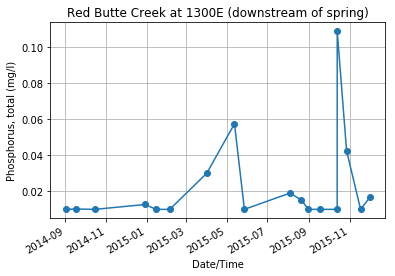

In [24]:
# Plot the time sequence of Measurement Result Values 
resultValues.plot(x='valuedatetime', y='datavalue', title=relatedSite.SamplingFeatureName,
                  kind='line', use_index=True, linestyle='solid', style='o')
ax = plt.gca()
ax.set_ylabel("{0} ({1})".format(results[0].VariableObj.VariableNameCV, 
                                 results[0].UnitsObj.UnitsAbbreviation))
ax.set_xlabel('Date/Time')
ax.grid(True)
ax.legend().set_visible(False)

### *Use the Force!* (We already used YODA ...)

If I'm going to reuse a series of steps, it's always helpful to write little generic functions that can be called to quickly and consistently get what we need. To conclude this demo, here's one such function that encapsulates the `VariableID`, `getResults` and `getResultValues` queries we showed above. Then we leverage it to create a nice 2-variable (2-axis) plot of TP and TN vs time, and conclude with a reminder that we have ready access to related metadata about analytical lab methods and such.

In [25]:
def get_results_and_values(siteid, variablecode):
    v = variables_df[variables_df['VariableCode'] == variablecode]
    variableID = v.index[0]
    
    results = read.getResults(siteid=siteid, variableid=variableID, type="Measurement")
    resultIDList = [x.ResultID for x in results]
    resultValues = read.getResultValues(resultids=resultIDList)
    
    return resultValues, results

Fancy plotting, leveraging the `Pandas` plot method and `matplotlib`.

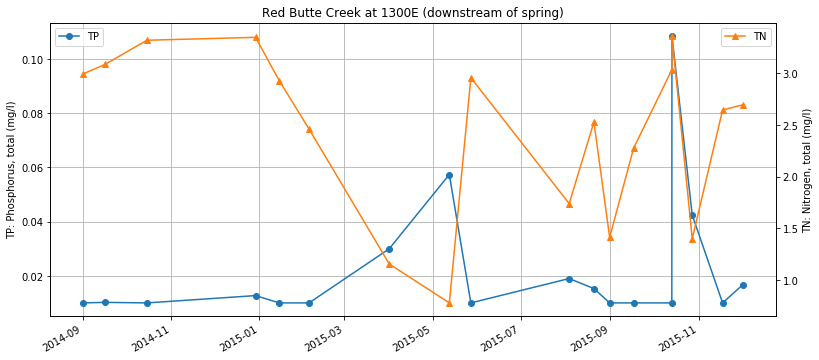

In [26]:
# Plot figure and axis set up (just *one* subplot, actually)
f, ax = plt.subplots(1, figsize=(13, 6))

# First plot (left axis)
VariableCode = 'TP'
resultValues_TP, results_TP = get_results_and_values(siteID, VariableCode)
resultValues_TP.plot(x='valuedatetime', y='datavalue', label=VariableCode, 
                     style='o-', kind='line', ax=ax)
ax.set_ylabel("{0}: {1} ({2})".format(VariableCode, results_TP[0].VariableObj.VariableNameCV, 
                                      results_TP[0].UnitsObj.UnitsAbbreviation))

# Second plot (right axis)
VariableCode = 'TN'
resultValues_TN, results_TN = get_results_and_values(siteID, VariableCode)
resultValues_TN.plot(x='valuedatetime', y='datavalue', label=VariableCode, 
                     style='^-', kind='line', ax=ax,
                     secondary_y=True)
ax.right_ax.set_ylabel("{0}: {1} ({2})".format(VariableCode, results_TN[0].VariableObj.VariableNameCV, 
                                               results_TN[0].UnitsObj.UnitsAbbreviation))

# Tweak the figure
ax.legend(loc=2)
ax.right_ax.legend(loc=1)

ax.grid(True)
ax.set_xlabel('')
ax.set_title(relatedSite.SamplingFeatureName);

Finally, let's show some useful metadata. Use the `Results` records and their relationship to `Actions` (via `FeatureActions`) to **extract and print out the Specimen Analysis methods used for TN and TP**. Or at least for the *first* result for each of the two variables; methods may have varied over time, but the specific method associated with each result is stored in ODM2 and available.

In [27]:
print("TP METHOD:  {0} ({1})".format(results_TP[0].FeatureActionObj.ActionObj.MethodObj.MethodName,
                                     results_TP[0].FeatureActionObj.ActionObj.MethodObj.MethodDescription))

print("TN METHOD:  {0} ({1})".format(results_TN[0].FeatureActionObj.ActionObj.MethodObj.MethodName,
                                     results_TN[0].FeatureActionObj.ActionObj.MethodObj.MethodDescription))

TP METHOD:  Astoria Total Phosphorus (Determination of total phosphorus by persulphate oxidation digestion and ascorbic acid method)
TN METHOD:  Astoria Total Nitrogen (Determination of total Nitrogen by persulphate oxidation digestion and cadmium reduction method)
